<a href="https://colab.research.google.com/github/sushruta/ml-notebooks/blob/main/efficientnet_cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cats and Dogs detection using Efficientnet model

Let us use efficientnet model B0 model to train a model that can take a picture of cats and dogs and return the animal in question.

Efficientnet models are there from B0 to B7 with increasing number of parameters in them. B0 model is attractive for the reason that it's a very small model compared to the accuracy it delivers.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(tf.__version__, keras.__version__)

2.3.0 2.4.0


In [ ]:
!pip install efficientnet

In [ ]:
import efficientnet.keras as enet

In [ ]:
IMG_SHAPE = (250, 250, 3)

base_model = enet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)

16809984/16804768 [==============================] - 1s 0us/step


In [ ]:
def get_dataset():
  from tensorflow.keras.preprocessing import image_dataset_from_directory
  import os

  _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
  path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
  PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

  train_dir = os.path.join(PATH, 'train')
  validation_dir = os.path.join(PATH, 'validation')

  BATCH_SIZE = 32
  IMG_SIZE = (250, 250)

  train_dataset = image_dataset_from_directory(
      train_dir,
      shuffle=True,
      batch_size=BATCH_SIZE,
      image_size=IMG_SIZE
  )

  validation_dataset = image_dataset_from_directory(
      validation_dir,
      shuffle=True,
      batch_size=BATCH_SIZE,
      image_size=IMG_SIZE
  )

  validation_batches = tf.data.experimental.cardinality(validation_dataset)

  test_dataset = validation_dataset.take(validation_batches // 5)
  validation_dataset = validation_dataset.skip(validation_batches // 5)

  return (train_dataset, validation_dataset, test_dataset)

In [ ]:
train_dataset, validation_dataset, test_dataset = get_dataset()

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Let us augment our dataset with some more data. Flip the images a bit here and there to get some new images

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)

In [ ]:
base_model.trainable = False

global_max_layer = tf.keras.layers.GlobalMaxPool2D()

prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

mid_layer = data_augmentation(inputs)
mid_layer = rescale(mid_layer)
mid_layer = base_model(mid_layer, training=False)
mid_layer = global_max_layer(mid_layer)
mid_layer = tf.keras.layers.Dropout(0.3)(mid_layer)

outputs = prediction_layer(mid_layer)

In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 250, 250, 3)       0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 8, 8, 1280)        4049564   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 2s 65ms/step - loss: 6.1523e-08 - accuracy: 0.4653


In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

Epoch 1/5
63/63 [==============================] - 7s 107ms/step - loss: 5.9605e-08 - accuracy: 0.4890 - val_loss: 6.0047e-08 - val_accuracy: 0.4629
Epoch 2/5
63/63 [==============================] - 7s 106ms/step - loss: 5.9605e-08 - accuracy: 0.4805 - val_loss: 5.9605e-08 - val_accuracy: 0.4691
Epoch 3/5
63/63 [==============================] - 7s 106ms/step - loss: 5.9605e-08 - accuracy: 0.4835 - val_loss: 6.1523e-08 - val_accuracy: 0.4616
Epoch 4/5
63/63 [==============================] - 7s 105ms/step - loss: 5.9605e-08 - accuracy: 0.4690 - val_loss: 6.0490e-08 - val_accuracy: 0.4616
Epoch 5/5
63/63 [==============================] - 7s 105ms/step - loss: 5.9605e-08 - accuracy: 0.4745 - val_loss: 6.0195e-08 - val_accuracy: 0.4666


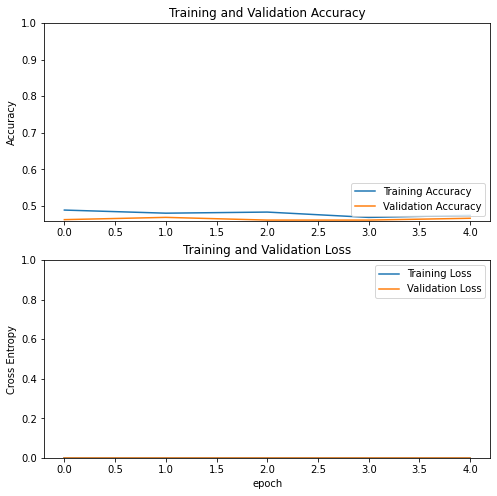

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

print("number of layers in the base model: {0}".format(len(base_model.layers)))

num_layers_to_retrain = 100
for layer in base_model.layers[:num_layers_to_retrain]:
  layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

number of layers in the base model: 230
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 250, 250, 3)       0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 8, 8, 1280)        4049564   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense) 

In [ ]:
history_fine = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 10s 151ms/step - loss: 0.3383 - accuracy: 0.8920 - val_loss: 0.0412 - val_accuracy: 0.9827
Epoch 2/10
63/63 [==============================] - 8s 135ms/step - loss: 0.1373 - accuracy: 0.9505 - val_loss: 0.0490 - val_accuracy: 0.9790
Epoch 3/10
63/63 [==============================] - 8s 134ms/step - loss: 0.0831 - accuracy: 0.9700 - val_loss: 0.0671 - val_accuracy: 0.9765
Epoch 4/10
63/63 [==============================] - 8s 135ms/step - loss: 0.0723 - accuracy: 0.9725 - val_loss: 0.0307 - val_accuracy: 0.9851
Epoch 5/10
63/63 [==============================] - 8s 135ms/step - loss: 0.0499 - accuracy: 0.9780 - val_loss: 0.0436 - val_accuracy: 0.9814
Epoch 6/10
63/63 [==============================] - 9s 135ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.0433 - val_accuracy: 0.9864
Epoch 7/10
63/63 [==============================] - 8s 134ms/step - loss: 0.0262 - accuracy: 0.9915 - val_loss: 0.0490 - val_accuracy: 0.9851
Epoch

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

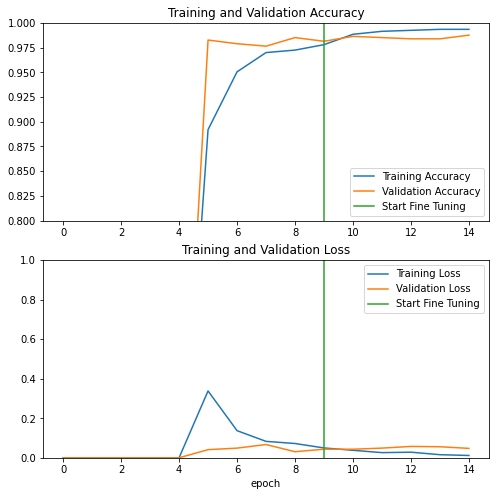

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 60ms/step - loss: 0.0856 - accuracy: 0.9844
Test accuracy : 0.984375


In [ ]:
all_preds = []
all_labels = []

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
for i in range(15):
  preds = model.predict_on_batch(image_batch).flatten()

  print(label_batch)

  preds = tf.nn.sigmoid(preds)
  preds = tf.where(preds < 0.5, 0, 1)

  all_preds = all_preds + preds.numpy().tolist()
  all_labels = all_labels + label_batch.tolist()

  image_batch, label_batch = test_dataset.as_numpy_iterator().next()

report = classification_report(
    all_labels,
    all_preds
)

print(report)

[1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0]
[0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1]
[0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1]
[0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1]
[0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1]
[0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0]
[1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1]
[0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1]
[1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1]
[0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0]
[1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]
[1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1]
[0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1]
[0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1]
          